### TDT17 - Implement the actor-critic architecture

The problem description is given in the provided pdf. This notebook will give you the tools necessary to solve the problem 
of implementing the actor-critic architecture and apply it so solve a simple problem of getting a decent score in 
the towers of hanoi game. You only need to add code in the places marked with `TODO`. If done correctly according
to the provided pseudocode, you should be able to run the notebook, and find a solution to the towers of hanoi problem 
where the number of moves are between 15-20 regurarly. 15 is the optimal number of moves. 

You only need to change the code in the main `while` loop in the last cell. I have done the initial setup for you.

#### *COPILOT NOT ALLOWED*

**GOOD LUCK!**

#### Parameters

In [31]:
class Parameters():

    def __init__(self):
        # World parameters
        self.world_type = "hanoi_towers" 

        # Episodes and steps
        self.num_episodes = 200
        self.episode_length = 300

        # Critic parameters
        self.critic_type = "table" 
        self.input_dims = {"hanoi_towers": self.get_tower_params()["peg_amount"]}
        self.critic_neural_dimentions = (self.input_dims[self.world_type], 20, 30, 5, 1)
        self.critic_learning_rate = 0.00065
        self.critic_eligibility_decay = 0.99
        self.critic_discount = 0.99

        # Actor parameters
        self.actor_learning_rate = 0.8
        self.actor_eligibility_decay = 0.7
        self.actor_discount = 0.98
        self.epsilon = 0.9
        self.epsilon_decay = 0.98

        # Visualization
        self.visualize = True


    def get_tower_params(self):
        return {
                "peg_amount": 3,  # [3, 5]
                "disc_amount": 4, # [2, 6]
                "episode_length": self.episode_length,
                "win_reward": 5 if self.critic_type == "neural" else 100
            }

    def get_problem_parameters(self):
        if self.world_type == "hanoi_towers":
            return self.get_tower_params()

#### World representation (Environment)

In [32]:
from functools import reduce

class HanoiTowersWorld():

    def __init__(self, parameters):
        self.params = parameters
        self.peg_amount = self.params["peg_amount"]
        self.disc_amount = self.params["disc_amount"]
        self.peg_states = self.generate_peg_states()
        self.reset()

    def reset(self):
        """
            Resets the world state and variables.

            num_moves is used for checking if we have lost (timeout basically)
            first_peg will contain all the discs. For a 4 disc problem, this will look like [1, 2, 3, 4]
            rest_of_pegs are the rest of the pegs, and they are all empty as all the discs are on the first peg
            The initial state will be these two lists added together
        """
        self.num_moves = 1
        first_peg = [[i + 1 for i in range(self.disc_amount)][::-1]]
        rest_of_pegs = [[] for _ in range(self.peg_amount - 1)]
        self.world_state = first_peg + rest_of_pegs

    def generate_peg_states(self):
        """
            This method will number the possible states in the problem so that we can look at a peg and say:
                "Yep. Thats peg state 2"
            This makes it easier to make connections between state and action for the neural network (if we use that approach)
            The list for a  4 disc problem will look like this:
            [[], [4], [3], [4, 3], [2], [4, 2], [3, 2], [4, 3, 2], [1], [4, 1], [3, 1], [4, 3, 1], [2, 1], [4, 2, 1], [3, 2, 1], [4, 3, 2, 1]]
        """
        def powerset(lst):
            return reduce(lambda result, x: result + [subset + [x] for subset in result],lst, [[]])
        return powerset([i for i in range(self.disc_amount, 0, -1)])

    def calculate_world_state(self):
        """
            Will return a list of peg states representing the current state.
            The length of the list depends on the amount of pegs in the problem
        """
        state = []
        for peg in self.world_state:
            state.append(self.peg_states.index(peg)) # Indexes the powerset calculated in generate_peg_states to get the number
        return state

    def get_current_state(self):
        """
            As the state has to be hashable, we convert the state representation to a tuple of integers
        """
        return tuple(self.calculate_world_state())

    def get_possible_actions(self):
        """
            This method will return a list of possible actions to perform. 
            It will loop through the pegs and check if a disc is eligable to move from one to another.
            If it is, then it will be added to the list in this representation (example):
                -- [(2, 0, 1), (1, 2, 0), (1, 2, 1)] --
                This means that:
                   disc 2 can move from peg 0 to peg 1
                   disc 1 can move from peg 2 to peg 0
                   disc 1 can move from peg 2 to peg 1

            So it returns a list of tuples with (disc, peg_from, peg_to)
        """
        possible_moves = []
        for i, peg1 in enumerate(self.world_state):
            if len(peg1) == 0:
                continue
            for j, peg2 in enumerate(self.world_state):
                if len(peg2) == 0: # If the peg is empty, we can move the disc there
                    possible_moves.append((peg1[-1], i, j))
                else:
                    if peg1[-1] < peg2[-1]: # The disc has to be smaller than the one it lands on
                        possible_moves.append((peg1[-1], i, j))
        return possible_moves

    def perform_action(self, action):
        """
            This method performs the action selected by the actor. It will select one of the elements in the list returned from get_possible_actions
            and will decode the message in the same way as the comment above.
              -- (2, 1, 0) --
              Will move disc 2 from peg 1 to peg 0
        """
        self.num_moves = self.num_moves + 1
        peg_from = action[1]
        peg_to = action[2]
        disc = self.world_state[peg_from][-1] # The disc on top of the peg we are moving it from
        self.world_state[peg_from] = self.world_state[peg_from][:-1] # Removes the last element (removes the disc)
        self.world_state[peg_to] = self.world_state[peg_to] + [disc] # Adds element (places disc)

    def get_visualization(self):
        """
            The visual representation for this problem is a bit weird. It will seperate each peg with a "|" and each disc with ","
            This is because the actual state representation of the pegs is encoded into the integers explaned earlier.
            The string returned from this method is decoded in the visualizer as follows:
            -- Initial position for 3 pegs and 4 discs --
                4,3,2,1||

                (1) Splits on "|" giving: ["4,3,2,1", "", ""]
                (2) Split each peg on "," giving: [["4", "3", "2", "1"], [], []]

                Now we can use the list to represent the pegs and discs
        """
        string = ""
        for disk in self.world_state:
            string += ",".join([str(x) for x in disk])
            string += "|"
        return string[:-1]

    def winning_state(self):
        """
            The state is winning if the last peg contains all the discs
        """
        return len(self.world_state[-1]) == self.disc_amount

    def losing_state(self):
        """
            The state is losing (timed out) if the AI has tried for too many moves
        """
        return self.num_moves == self.params["episode_length"]

    def is_end_state(self):
        """
            Returns true if the world is in an end state (either winning or losing)
        """
        return self.winning_state() or self.losing_state()

    def get_reward(self):
        """
            We will give a negative reward trying to tell the AI to find the solution with the "least worse" total reward (the smallest negative number)
            If we hit the winning state, we give the AI an additional reward spesified in parameters.py. These are different for the table and neural network critics. 
        """
        if self.winning_state():
            return self.params["win_reward"]
        return -1



#### Actor and Critic

Both the actor and the critic uses table-based representation for the policy and value function respectively.
These representations can also be implemented as neural networks, as discussed in the provided video.

In [33]:
import random

class Actor():

    def __init__(self, learning_rate, eligibility_decay, discount, epsilon, epsilon_decay):
        """
            Constructor initializing values for the Actor class. 
            Everything except the "policy" and "eligibility" is provided by the caller.
        """
        self.learning_rate = learning_rate
        self.eligibility_decay = eligibility_decay
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.policy = {}
        self.eligibility = {}
        self.SAPs = []

    def add_to_sap(self, sap):
        """
            Will add the state and action to the history of the given episode
        """
        self.SAPs.append(sap)

    def add_to_policy(self, sap):
        """
            If the state-action pair is not in the policy, we add it with a reward of 0.
        """
        if sap not in self.policy:
            # This works as an initialization for unseen states.
            self.policy[sap] = 0

    def add_to_eligibility(self, sap):
        """
            If the state-action pair is not in the eligibility, we add it with a reward of 1.
        """
        if sap not in self.eligibility:
            # This works as an initialization for unseen states.
            # Same asline 3 in the algorithm under section 3.1 in actor-critic.pdf
            self.eligibility[sap] = 1

    def reset(self):
        """
            Resets eligibility to empty dictionary
        """
        # Updates epsilon for each episode
        self.epsilon = self.epsilon * self.epsilon_decay
        self.eligibility = {}
        self.SAPs = []

    def select_action(self, state, possible_actions):
        """
            Decides which action the actor should do. If the random value is larger than the epsilon it 
            loops through the possible actions given from the world, and calculates the best action by choosing the one with the best reward.
            If the random value is smaller than epsilon, a random action is chosen. 
            This works as line 2 in the algorithm under section 3.1 in actor-critic.pdf.
        """
        best_action = random.choice(possible_actions)
        random_value = random.random()
        if random_value > self.epsilon:
            highest_reward = float("-inf")
            for move in possible_actions:
                sap = (state, move)
                self.add_to_policy(sap)
                reward = self.policy[sap]
                if reward > highest_reward:
                    best_action = move
                    highest_reward = reward 
        return best_action

    def learn(self, error):
        """
            Updates the "policy" and "eligibility" with the given error and actor properties. 
        """
        for sap in self.SAPs:
            self.add_to_policy(sap)
            self.add_to_eligibility(sap)
            # Works as line 6c in the already referenced algorithm
            self.policy[sap] = self.policy[sap] + self.learning_rate * error * self.eligibility[sap]
            # Works as line 6d in the already referenced algorithm
            self.eligibility[sap] = self.discount * self.eligibility_decay * self.eligibility[sap]

class Critic():

    def __init__(self, learning_rate, eligibility_decay, discount):
        """
            Constructor initializing values for the TableCritic class. 
            Everything except the "rewards", "eligibility" and "error" is provided by the caller.
        """
        self.learning_rate = learning_rate
        self.eligibility_decay = eligibility_decay
        self.discount = discount
        self.rewards = {}
        self.eligibility = {}
        self.error = 0
        self.SRPs = []

    def add_to_srp(self, srp):
        """
            Will add the state and reward to the history of the given episode
        """
        self.SRPs.append(srp)
        
    def reset(self):
        """
            Resets eligibility to empty dictionary
        """
        self.eligibility = {}
        self.SRPs = []

    def learn(self):
        """
            Updates the "rewards" and "eligibility" with the given error and actor properties. 
        """
        if len(self.SRPs) == 2:
            self.eligibility[self.SRPs[0][0]] = self.discount * self.eligibility_decay
        self.eligibility[self.SRPs[-1][0]] = 1
        for SRP in self.SRPs:
            # Works as line 6a in the algorithm in section 3.1 in actor-critic.pdf
            self.rewards[SRP[0]] = self.rewards[SRP[0]] + self.learning_rate * self.error * self.eligibility[SRP[0]]
            # Works as line 6b in the same algorithm
            self.eligibility[SRP[0]] = self.discount * self.eligibility_decay * self.eligibility[SRP[0]]

    def calculate_error(self, prev, new, reward):
        """
            The parameter "states" is a tuple containing the old and new state. 
            The method will update the td_error for the critic based on the actual reward and the two states.
        """
        if new not in self.rewards:
                self.rewards[new] = random.random() / 10
        if prev not in self.rewards:
                self.rewards[prev] = random.random() / 10
        # Works as line 4 in the algorithm in section 3.1 in actor-critic.pdf
        self.error = reward + (self.discount * self.rewards[new]) - self.rewards[prev]
        return self.error

#### Visualizer

In [34]:
import matplotlib.pyplot as plt
import numpy as np

class Visualiser():
    """
        Generalized visualizer using the correct subclass depending on the world_type
    """

    def __init__(self, data, params):
        self.worker = HanoiTowersVisualizer(data, params)

    def show(self):
        """
            Every subclass has this method, and creates the visualization needed
        """
        return self.worker.show()

class HanoiTowersVisualizer():
    """
        Used for the Towers of Hanoi visualization
    """

    def __init__(self, data, params):
        self.episodes = data[0]
        self.episode = data[1]
        self.params = params

    def show(self):
        spes = self.params.get_problem_parameters()
        disc_amount = spes["disc_amount"]

        length = len(self.episode)
        print("Final episode ran for", length - 1, "moves" )
        print("The run was a " + ("SUCCESS" if len(self.episode[-1].split("|")[-1].split(",")) == disc_amount else "FAILURE"))
        self.make_graph()
            
       
    def make_graph(self):
        plt.figure()
        plt.title('Results for the Towers of Hanoi')
        # Axis variables
        episode_lengths = [len(e) - 1 for e in self.episodes] # - 1 as we want the amount of moves, and not states (16 states means 15 moves)
        plt.plot(np.arange(len(self.episodes)), episode_lengths)
        plt.xlabel("Episode number")
        plt.ylabel("Move count")

        plt.show()

#### Main loop and run function

---- Ran 200 episodes ----
Final episode ran for 16 moves
The run was a SUCCESS


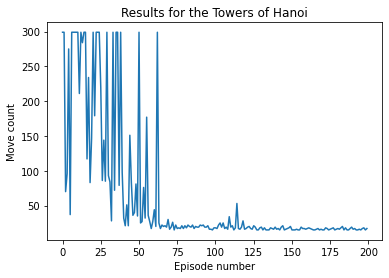

In [35]:
PARAMS = Parameters()

def run_episode(actor, critic, world):
    # Resetting things before each episode
    world.reset()
    actor.reset()
    critic.reset()

    # Initializing state-action list and state-reward list
    state, reward = world.get_current_state(), world.get_reward()
    # Agent chooses first action
    action = actor.select_action(state, world.get_possible_actions())
    # Adding the state-action and state-reward pairs to the episode history in actor and critic
    actor.add_to_sap((state, action))
    critic.add_to_srp((state, reward))
    
    # Storing episode states for visualization
    episode_visualization = [world.get_visualization()]

    # ================================= CODE BETWEEN HERE =================================

    # Run episode steps
    while True:
        
        # DONE: Fetch world state and the next action chosen
        state = world.get_current_state()
        action = actor.select_action(state, world.get_possible_actions())

        # DONE: Add the state-action pair as a tuple to the actor's SAPs (State-Action Pairs)
        actor.add_to_sap((state, action))

        # DONE: Perform the action in the world
        world.perform_action(action)

        # DONE: Fetch the new world state and the reward
        new_state = world.get_current_state()
        reward = world.get_reward()

        # DONE: Add the state-reward pair as a tuple to the critic's SRPs (State-Reward pairs)
        critic.add_to_srp((state, reward))

        # DONE: Use the critic to calculate the error based on the previous state, the new state and the reward
        error = critic.calculate_error(state, new_state, reward)

        # DONE: Use the error to learn the actor, and call the critics learn method
        actor.learn(error)
        critic.learn()

        # Storing data used for visualization
        episode_visualization.append(world.get_visualization())

        # Checking if we are done, and updating neural network if we're using it
        if world.is_end_state():
            break

    # ================================= END OF CODE CHANGES =================================

    # Returns the data needed for visualization. It is only used when the parameter is set, but will always be returned
    return episode_visualization

def visualize(actor, critic, world):
    if PARAMS.visualize:
        # Setting epsilon to 0 so that the greedy-strategy is on display
        actor.epsilon = 0

        # Asking actor what to do for every state (1-99) for plotting
        if PARAMS.world_type == "the_gambler":
            data = []
            for i in range(1, 100):
                bet = actor.select_action(i, [j for j in range(1, min(i + 1, 100 - i + 1))])
                data.append(bet)
            data = [0] + data + [0] # This is to secure shapes (0 and 100 are end states, but should be on the graph)
        else:
            # Running an episode
            episode = run_episode(actor, critic, world)
            data = (episodes, episode)

        # Visualizing results
        visualiser = Visualiser(data, PARAMS)
        visualiser.show()

    
if __name__ == "__main__":
    # Initializing actor, critic and world
    critic = Critic(PARAMS.critic_learning_rate, PARAMS.critic_eligibility_decay, PARAMS.critic_discount)
    actor = Actor(PARAMS.actor_learning_rate, PARAMS.actor_eligibility_decay, PARAMS.actor_discount, PARAMS.epsilon, PARAMS.epsilon_decay)
    world = HanoiTowersWorld(PARAMS.get_problem_parameters())

    # Used for visualization in both pole balancing and towers of hanoi
    episodes = []

    # Running episodes
    for episode_nr in range(PARAMS.num_episodes):
        episodes.append(run_episode(actor, critic, world))

    print(f"---- Ran {episode_nr + 1} episodes ----")

    visualize(actor, critic, world)
        